In [1]:
import numpy as np 
import pandas as pd 


import numpy as np
import os
import cv2
import pandas as pd
import joblib
from pathlib import Path

from keras.applications import  vgg19
from keras.applications.vgg19 import  VGG19
from keras.applications.vgg19 import preprocess_input
from keras.models import  Model

from keras.preprocessing import image
from keras.layers import Dense,Flatten,Dropout,InputLayer
from keras.models import Sequential

from keras.utils.vis_utils import plot_model
from keras import optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
! pip install kaggle

In [3]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import json

token = {"username":"XXXXX","key":"xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [5]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
#Configure the file
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria -p /content

cell-images-for-detecting-malaria.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import os
import zipfile

local_zip = '/content/cell-images-for-detecting-malaria.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/cell-images-for-detecting-malaria')
zip_ref.close()

In [0]:
infected_cells = os.listdir('/content/cell-images-for-detecting-malaria/cell_images/Parasitized/')
uninfected_cells = os.listdir('/content/cell-images-for-detecting-malaria/cell_images/Uninfected/')

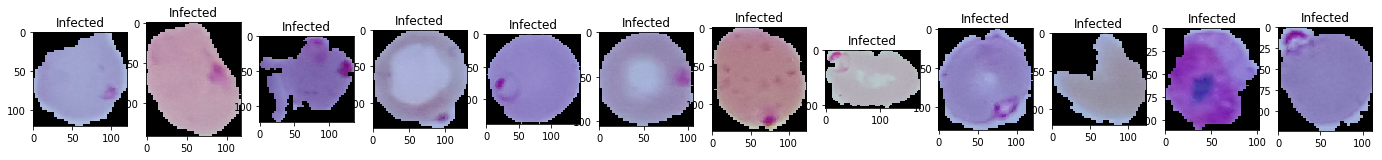

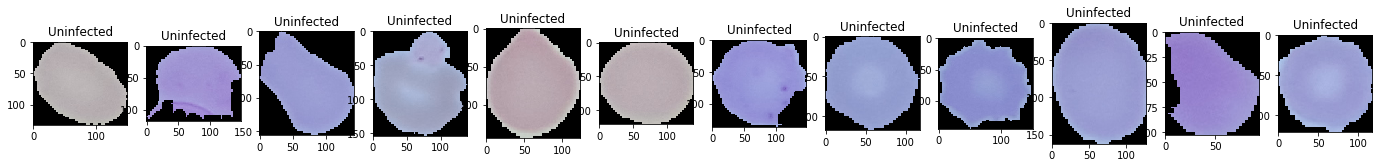

In [10]:
plt.figure(figsize=(24,24))
for i in range(12):
    plt.subplot(1,12,i+1)
    img = cv2.imread('/content/cell-images-for-detecting-malaria/cell_images/Parasitized/'+infected_cells[i])
    plt.imshow(img)
    plt.title('Infected')
plt.figure(figsize=(24,24))
for i in range(12):
    plt.subplot(1,12,i+1)
    img2 = cv2.imread('/content/cell-images-for-detecting-malaria/cell_images/Uninfected/'+uninfected_cells[i])
    plt.imshow(img2)
    plt.title('Uninfected')

In [0]:
img = image.load_img("/content/cell-images-for-detecting-malaria/cell_images/Uninfected/C241NThinF_IMG_20151207_124643_cell_169.png")
img1 = image.load_img("/content/cell-images-for-detecting-malaria/cell_images/Parasitized/C189P150ThinF_IMG_20151203_142224_cell_98.png")

In [0]:
def load_images_from_folder(folder,lent):
    
    
    count = 0
    images = []
    
    
    for filename in os.listdir(folder):

#        img = cv2.imread(os.path.join(folder,filename))
        img = image.load_img(os.path.join(folder,filename),target_size=(224,224))
        img = image.img_to_array(img)
        img = preprocess_input(img)
        
        
        if img is not None:
            images.append(img)
        
        count = count + 1
        
        if count == lent:
            break
            
    return images

def array_to_df(arr_as_list,label_name):
    
    temp_arr = np.array(arr_as_list)
    temp_arr = np.reshape(temp_arr,(temp_arr.shape[0],224*224*3 ) )
    
    
        
    temp_label =[]
    
    for i in range(0,temp_arr.shape[0]):
        temp_label.append(label_name)
    
    temp_label  = np.asarray(temp_label)
    
    image_df = pd.DataFrame(temp_arr)
    label_df = pd.DataFrame(temp_label)    
        
    total_df = pd.concat([image_df,label_df],axis=1)
    
    return total_df


In [0]:
Uninfected = load_images_from_folder('/content/cell-images-for-detecting-malaria/cell_images/Uninfected',500)
Parasitized = load_images_from_folder('/content/cell-images-for-detecting-malaria/cell_images/Parasitized',500)

Uninfected_df = array_to_df(Uninfected,'Uninfected')
Parasitized_df = array_to_df(Parasitized,'Infected')

total_df = pd.concat([Uninfected_df,Parasitized_df],axis=0)
total_array = np.array(total_df)


x = total_array[:,0:-1]
y = total_array[:,-1]

In [14]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(y)
y = lb.transform(y)


print(x.shape)
print(y.shape)

x_train,x_val,y_train,y_val = train_test_split(x,y,test_size = 0.1)

print('x_train : ', x_train.shape)
print('x_val : ', x_val.shape)
print('y_train : ', y_train.shape)
print('y_val : ', y_val.shape)

(1000, 150528)
(1000, 1)
x_train :  (900, 150528)
x_val :  (100, 150528)
y_train :  (900, 1)
y_val :  (100, 1)


In [15]:
x_train = x_train/225
x_val = x_val/225

vgg = vgg19.VGG19(include_top=False, weights='imagenet',input_shape=(224,224,3)) 
 
output = vgg.layers[-1].output 
output = Flatten()(output) 
base_model = Model(vgg.input, output) 
base_model.trainable = False 
 
for layer in base_model.layers: 
    layer.trainable = False

W0827 18:46:20.126733 140119785080704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 18:46:20.141054 140119785080704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 18:46:20.145049 140119785080704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 18:46:20.173918 140119785080704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0827 18:46:20.651275 140119785080704 deprecation_wrapp

In [16]:
base_model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
def get_bottleneck_features(model, input_imgs): 
    features = model.predict(input_imgs, verbose=0) 
    return features 

train_features_vgg = get_bottleneck_features(base_model, np.reshape(x_train,(900,224,224,3))) 
validation_features_vgg = get_bottleneck_features(base_model, np.reshape(x_val,(100,224,224,3)))

In [18]:
input_shape = base_model.output_shape[1] 
model = Sequential() 
model.add(InputLayer(input_shape=(input_shape,))) 
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3)) 
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['accuracy']) 

W0827 18:46:40.441558 140119785080704 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0827 18:46:40.519083 140119785080704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0827 18:46:40.529167 140119785080704 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 13,108,737
Trainable params: 13,108,737
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(train_features_vgg,y_train,epochs=30,validation_data=(validation_features_vgg,y_val),steps_per_epoch=10,validation_steps=50)

Train on 900 samples, validate on 100 samples
Epoch 1/30
10/10 [==============================] - 1s 133ms/step - loss: 1.0395 - acc: 0.5548 - val_loss: 0.6467 - val_acc: 0.5900
Epoch 2/30
10/10 [==============================] - 1s 76ms/step - loss: 0.6527 - acc: 0.6134 - val_loss: 0.6844 - val_acc: 0.5800
Epoch 3/30
10/10 [==============================] - 1s 80ms/step - loss: 0.6175 - acc: 0.6386 - val_loss: 0.6072 - val_acc: 0.6400
Epoch 4/30
10/10 [==============================] - 1s 79ms/step - loss: 0.5934 - acc: 0.6652 - val_loss: 0.6775 - val_acc: 0.5500
Epoch 5/30
10/10 [==============================] - 1s 76ms/step - loss: 0.5638 - acc: 0.7012 - val_loss: 0.5761 - val_acc: 0.6800
Epoch 6/30
10/10 [==============================] - 1s 77ms/step - loss: 0.5281 - acc: 0.7170 - val_loss: 0.5990 - val_acc: 0.6500
Epoch 7/30
10/10 [==============================] - 1s 81ms/step - loss: 0.5022 - acc: 0.7364 - val_loss: 0.6862 - val_acc: 0.6000
Epoch 8/30
10/10 [==================

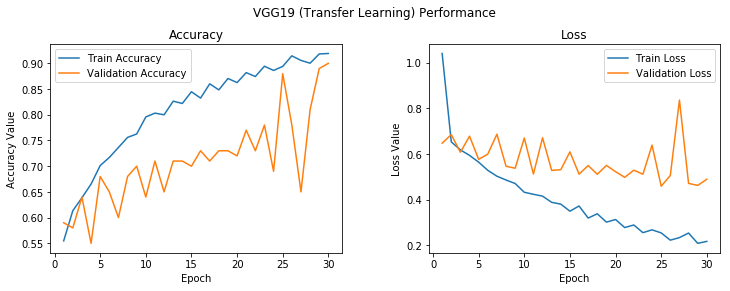

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG19 (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
